The lower limit of $T^{0\nu\beta\beta}_{1/2}$ is given by
$$ T^{0\nu\beta\beta}_{1/2}|_{\text{low}}  = \text{log}(2) t \frac{\epsilon_s}{S(b)} N_0$$

$$ S(T^{0\nu\beta\beta}_{1/2}) \propto \epsilon_s \sqrt{\frac{t \cdot M}{b \cdot \Delta E}}$$

In the large background approximation: $S(b) = \alpha(\text{C.L.})\sqrt{b}$


The sensitivity of a $0\nu\beta\beta$ experiment is proportional to the value
$$\text{figure of merit} = \frac{\epsilon_s}{\sqrt{\epsilon_b}}$$
were $\epsilon_{s, b}$ are the selection efficiencies for signal and background after the selection cuts.

If no cuts are applied, the figure of merit is 1, therefore any cut that improves sensitivity must fullfil
$$\frac{\epsilon_s}{\sqrt{\epsilon_b}} > 1 $$

In [1]:
import os
import sys
import time
import glob
import tables as tb
import pandas as pd
import numpy  as np

from itertools import combinations

from invisible_cities.core.system_of_units import kg, dalton, year, mBq, m3, mm, m, s
from invisible_cities.evm.mixer            import get_file_number

from invisible_cities.io.dst_io            import load_dst, load_dsts
from invisible_cities.database.load_db     import RadioactivityData

%matplotlib ipympl
import matplotlib.pyplot as plt

plt.rcParams["figure.max_open_warning"] = False

In [2]:
get_isotope_name  = lambda name: name.split("/")[-5]
get_g4volume_name = lambda name: name.split("/")[-4] 

def load_tracks_with_info(filenames):
    
    tracks = pd.DataFrame()
    for f, filename in enumerate(filenames, 1):
        
        print(f"Processed {f} / {len(filenames)}", end="\r")
        
        try:
            tracks_ = pd.read_hdf(filename, f"Tracking/Tracks").set_index("event")
        except:
            #print(filename)
            continue
        # energy cut
        energies = tracks_.groupby(level=0).energy.sum()
        sel = (2.40 <= energies) & (energies <= 2.50)
        tracks_ = tracks_.loc[sel].reset_index()
        tracks_["G4Volume"] = get_g4volume_name(filename)
        tracks_["file"]     = get_file_number(filename)

        tracks = pd.concat([tracks, tracks_])
        
    return tracks


def remove_spurious_tracks(tracks, spurious_energy):
    # remove spurious tracks and assign energy to largest energy track:
    # sum spurious track energies to max energy track and
    # correct numb_of_tracks values

    # tracks index must be (event, file) (ie levels 0 and 1)
    tracks = tracks.set_index("trackID", append=True)

    sel_spurious = (tracks.energy < spurious_energy)
    if not sel_spurious.any(): return tracks
    spurious_energies = tracks.loc[sel_spurious].groupby(level=[0, 1]).energy.sum()

    # trackID of max energy track
    trackID = tracks.reset_index(level=2).loc[spurious_energies.index] \
                    .set_index("trackID", append=True).groupby(level=[0, 1]) \
                    .apply(lambda df: df.energy.idxmax()[-1])
    trackID.name = "trackID"

    # sum spurious energy to max energy track
    spurious_energies = pd.merge(spurious_energies, trackID, left_index=True, right_index=True)\
                        .set_index("trackID", append=True)
    tracks.loc[spurious_energies.index, "energy"] += spurious_energies.energy

    # drop spurious
    tracks = tracks.loc[~sel_spurious].reset_index("trackID")
    # correct numb of tracks
    tracks.loc[:, "numb_of_tracks"] = tracks.groupby(level=[0, 1]).trackID.nunique()

    return tracks

In [3]:
act_df, mceff_df = RadioactivityData("next100")
flux = 5.26e-3 /(m**2 * s)
A    = (2*np.pi*(7.64 + 3) * m) * (39.3 * m) 
muon_activity = flux * A /mBq
act_df.loc[len(act_df)] = ("LAB_WALLS", "muons", muon_activity) # muon flux (in mBq)

# mc eff
mceff_df = pd.read_csv("mcefficiencies_2.4_2.5.csv")
mceff_df.loc[len(mceff_df)] = ("muons", "LAB_WALLS", 195800000, 3518) #from nexus
mceff_df["MCEfficiency"] = mceff_df.nsaved / mceff_df.nsim

# ic eff
iceff_df = pd.read_csv("efficiencies_ic_2.4_2.5.csv")
iceff_df.loc[len(mceff_df)] = ("muons", "LAB_WALLS", 3518, 3518)

# simulated exposure
index = ["Isotope", "G4Volume"]
iceff_df = iceff_df.set_index(index)
act_df   =   act_df.set_index(index)
mceff_df = mceff_df.set_index(index)

iceff_df["exposure"] = ((iceff_df.nsim/(mceff_df.MCEfficiency*act_df.TotalActivity * mBq))/year)

In [4]:
exposure   = 100.
enrichment = 0.9
xenon_density = 78.949 * kg/m3
volume        = np.pi*(490*mm)**2*1200*mm
xenon_mass = (xenon_density * volume)
N0 = enrichment*(xenon_mass/(136. * dalton))

iceff_df.loc[("0nubb", "ACTIVE"), "exposure"] = exposure

T12_0nubb = (N0 * np.log(2) * exposure) / iceff_df.loc[("0nubb", "ACTIVE")].nsim

print("simulated 0nubb half-life (years):", T12_0nubb)

simulated 0nubb half-life (years): 1.316008320847196e+24


In [5]:
path = os.path.expandvars("$HOME/NEXT/DATA/production/{isotope}/{g4volume}/prod/isaura/isaura_*.h5")

t0 = time.time()
filenames = glob.glob(path.format(isotope="0nubb", g4volume="*"))
tracks_0nubb = load_tracks_with_info(filenames).set_index(["event", "file"])
print("Time:", (time.time()-t0) / 60)

Time: 0.24311588207880655


In [6]:
t0 = time.time()
filenames = glob.glob(path.format(isotope="214Bi", g4volume="*"))
tracks_214Bi = load_tracks_with_info(filenames).set_index(["event", "file"])
print("Time:", (time.time()-t0) / 60)

Time: 3.3412893811861673


In [7]:
t0 = time.time()
filenames = glob.glob(path.format(isotope="208Tl", g4volume="*"))
tracks_208Tl = load_tracks_with_info(filenames).set_index(["event", "file"])
print("Time:", (time.time()-t0) / 60)

Time: 19.20006275177002


In [8]:
t0 = time.time()
filenames = glob.glob(path.format(isotope="muons", g4volume="/"))
tracks_muons = load_tracks_with_info(filenames).set_index(["event", "file"])
tracks_muons.loc[:, "G4Volume"] = "LAB_WALLS"
print("Time:", (time.time()-t0) / 60)

Time: 0.0013915657997131347


In [12]:
filenames = glob.glob(path.format(isotope="muons", g4volume="/"))
tracks = load_dsts(filenames, "Tracking", "Tracks").set_index("event")

# filenames = glob.glob(path.format(isotope="208Tl", g4volume="*"))[:200]
# tracks = load_dsts(filenames, "Tracking", "Tracks")

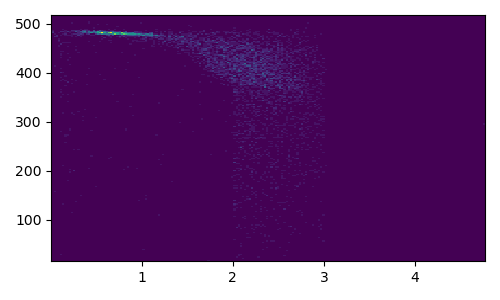

In [13]:
energies = tracks.groupby("event").energy.sum()
r_ave = tracks.groupby("event").r_ave.max()

plt.figure(figsize=[5, 3])
plt.hist2d(energies, r_ave, bins=200)
plt.tight_layout()

In [14]:
spurious_energy = 0.01

# remove spurious
tracks_0nubb = remove_spurious_tracks(tracks_0nubb, spurious_energy)
tracks_214Bi = remove_spurious_tracks(tracks_214Bi, spurious_energy)
tracks_208Tl = remove_spurious_tracks(tracks_208Tl, spurious_energy)
tracks_muons = remove_spurious_tracks(tracks_muons, spurious_energy)

In [15]:
# add exposures to normalice each G4Volume contribution in further analysis

tracks_208Tl.reset_index(inplace=True)
tracks_214Bi.reset_index(inplace=True)
tracks_muons.reset_index(inplace=True)

tracks_208Tl.set_index("G4Volume", inplace=True)
tracks_214Bi.set_index("G4Volume", inplace=True)
tracks_muons.set_index("G4Volume", inplace=True)

tracks_208Tl.loc[:, "exposure"] = iceff_df.loc["208Tl"].exposure
tracks_214Bi.loc[:, "exposure"] = iceff_df.loc["214Bi"].exposure
tracks_muons.loc[:, "exposure"] = iceff_df.loc["muons"].exposure

tracks_208Tl.reset_index(inplace=True)
tracks_214Bi.reset_index(inplace=True)
tracks_muons.reset_index(inplace=True)

tracks_208Tl.set_index(["event", "file"], inplace=True)
tracks_214Bi.set_index(["event", "file"], inplace=True)
tracks_muons.set_index(["event", "file"], inplace=True)

In [16]:
# plt.figure()
# bins=np.arange(0, 2.55, 0.01)
# plt.hist(tracks_0nubb.groupby(level=[0, 1]).energy.sum(), bins=bins)

# sel = (tracks_0nubb.groupby(level=[0,1]).r_max.max()>450)
# plt.hist(tracks_0nubb.loc[sel].groupby(level=[0, 1]).energy.sum(), bins=bins)
# plt.tight_layout()

In [17]:
# number of events after each cut for backgrounds
selections = [ "nexus"
             , "reco"
             , "energy"
             , "fiducial"
             , "track"
             , "overlap"
             , "ROI"
             , "topo"]

selections_df = pd.DataFrame(columns=selections)
selections_df.loc[:, "nexus"] = (iceff_df.nsim /iceff_df.exposure).groupby(level=0).sum()
selections_df.loc[:,  "reco"] = (iceff_df.nreco/iceff_df.exposure).groupby(level=0).sum()

# energy cut 
selections_df.loc["0nubb", "energy"] = tracks_0nubb.index.nunique()/iceff_df.loc[("0nubb", "ACTIVE")].exposure

selections_df.loc["208Tl", "energy"] = \
(tracks_208Tl.groupby("G4Volume").apply(lambda df: df.index.nunique())/iceff_df.loc["208Tl"].exposure).sum()

selections_df.loc["214Bi", "energy"] = \
(tracks_214Bi.groupby("G4Volume").apply(lambda df: df.index.nunique())/iceff_df.loc["214Bi"].exposure).sum()

selections_df.loc["muons", "energy"] = tracks_muons.index.nunique()/iceff_df.loc[("muons", "LAB_WALLS")].exposure

In [18]:
selections_df

,nexus,reco,energy,fiducial,track,overlap,ROI,topo
Isotope,,,,,,,,
0nubb,150.000000,125.220000,81.14,NaN,NaN,NaN,NaN,NaN
208Tl,1016.123270,1016.098278,100.343232,NaN,NaN,NaN,NaN,NaN
214Bi,108.858939,108.834183,47.156956,NaN,NaN,NaN,NaN,NaN
muons,7830.500929,7830.500929,701.139225,NaN,NaN,NaN,NaN,NaN


In [19]:
selections_df.energy/selections_df.reco

Isotope
0nubb     0.64798
208Tl    0.098753
214Bi    0.433292
muons     0.08954
dtype: object

## Fiducialization

Efficiency: 0.9272746353237485


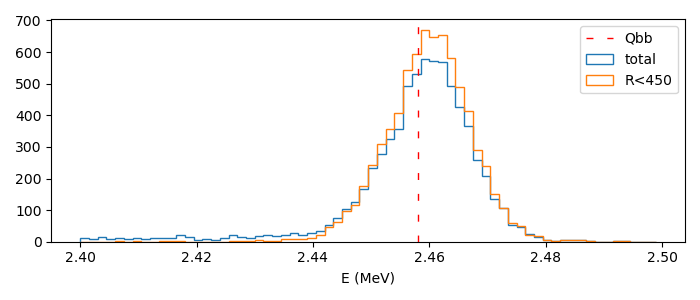

In [13]:
plt.figure(figsize=[7, 3])

rmax = 450
zmin = 20
zmax = 1180

bins = np.arange(2.40, 2.50, 0.0015)

plt.hist(tracks_0nubb.energy, bins=bins, histtype="step", label="total")

sel = (tracks_0nubb.r_max < rmax) & (zmin<tracks_0nubb.z_min) & (tracks_0nubb.z_max < zmax)
print("Efficiency:", sel.sum()/tracks_0nubb.index.size)

plt.hist( tracks_0nubb.loc[sel].groupby(level=[0,1]).energy.sum()
        , bins=bins, histtype="step", label=f"R<{rmax}")
Qbb = 2.458
plt.axvline(Qbb, c="r", linewidth=1, linestyle=(0, (5, 10)), label="Qbb")
plt.xlabel("E (MeV)")

plt.legend()
plt.tight_layout();

In [14]:
rmax = 450
zmin = 20
zmax = 1180

sel_0nubb = (tracks_0nubb.r_max < rmax) & (zmin<tracks_0nubb.z_min) & (tracks_0nubb.z_max<zmax)
rate = (tracks_0nubb.loc[sel_0nubb].index.nunique() / iceff_df.loc[("0nubb", "ACTIVE")].exposure).sum()
selections_df.loc["0nubb", "fiducial"] = rate

# 214Bi
sel_214Bi = (tracks_214Bi.r_max < rmax) & (zmin<tracks_214Bi.z_min) & (tracks_214Bi.z_max<zmax)
rate = (tracks_214Bi.loc[sel_214Bi].groupby("G4Volume").apply(lambda df: df.index.nunique()) / iceff_df.loc["214Bi"].exposure).sum()
selections_df.loc["214Bi", "fiducial"] = rate

# 208Tl
sel_208Tl = (tracks_208Tl.r_max < rmax) & (zmin<tracks_208Tl.z_min) & (tracks_208Tl.z_max<zmax)
rate = (tracks_208Tl.loc[sel_208Tl].groupby("G4Volume").apply(lambda df: df.index.nunique()) / iceff_df.loc["208Tl"].exposure).sum()
selections_df.loc["208Tl", "fiducial"] = rate

# muons
sel_muons = (tracks_muons.r_max < rmax) & (zmin<tracks_muons.z_min) & (tracks_muons.z_max<zmax)
rate = (tracks_muons.loc[sel_muons].groupby("G4Volume").apply(lambda df: df.index.nunique()) / iceff_df.loc["muons"].exposure).sum()
selections_df.loc["muons", "fiducial"] = rate

es = selections_df.loc["0nubb"].fiducial/selections_df.loc["0nubb"].energy
eb = selections_df.loc[("208Tl", "214Bi", "muons"), :].fiducial.sum()/selections_df.loc[("208Tl", "214Bi", "muons"), :].energy.sum()
 
print(f"fiducial cut: fom =", round(es/np.sqrt(eb), 2))

fiducial cut: fom = 1.2


In [15]:
print("fiducial selection efficiency")
print("----------------------------")
selections_df.fiducial/selections_df.energy

fiducial selection efficiency
----------------------------


Isotope
0nubb    0.929874
208Tl    0.861155
214Bi    0.931505
muons    0.498413
dtype: object

## Track multiplicity

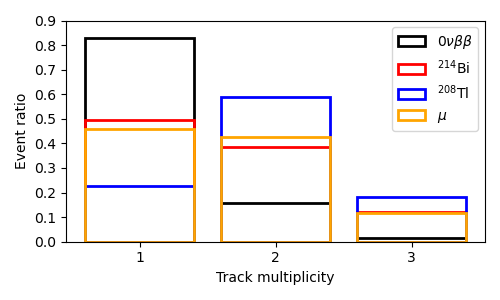

In [16]:
plt.figure(figsize=[5,3])

bins = np.arange(0.5, 4.5, 1)
binc = (bins[1:] + bins[:-1])/2.

# signal
h, _ = np.histogram( tracks_0nubb.loc[sel_0nubb].groupby(level=[0,1]).numb_of_tracks.max(), bins=bins)
plt.bar(binc, h/h.sum(), label=r"$0\nu\beta\beta$", color="none", edgecolor="k", linewidth=2)

# background
h, _ = np.histogram( tracks_214Bi.loc[sel_214Bi].groupby(level=[0,1]).numb_of_tracks.max(), bins=bins
          , weights= tracks_214Bi.loc[sel_214Bi].groupby(level=[0,1]).exposure.max())
plt.bar(binc, h/h.sum(), label=r"$^{214}$Bi", color="none", edgecolor="r", linewidth=2)

h, _ = np.histogram( tracks_208Tl.loc[sel_208Tl].groupby(level=[0,1]).numb_of_tracks.max(), bins=bins
          , weights= tracks_208Tl.loc[sel_208Tl].groupby(level=[0,1]).exposure.max())
plt.bar(binc, h/h.sum(), label=r"$^{208}$Tl", color="none", edgecolor="b", linewidth=2)

h, _ = np.histogram( tracks_muons.loc[sel_muons].groupby(level=[0,1]).numb_of_tracks.max(), bins=bins
          , weights= tracks_muons.loc[sel_muons].groupby(level=[0,1]).exposure.max())
plt.bar(binc, h/h.sum(), label=r"$\mu$", color="none", edgecolor="orange", linewidth=2)

plt.legend()
plt.ylabel("Event ratio")
plt.xlabel("Track multiplicity")
plt.xticks(binc)
plt.yticks(np.arange(0, 1, 0.1))
plt.tight_layout()

In [17]:
# ntracks = 1
n = 1

sel  = sel_0nubb & (tracks_0nubb.numb_of_tracks <= n)
rate = (tracks_0nubb.loc[sel].index.nunique() / iceff_df.loc[("0nubb", "ACTIVE")].exposure).sum()
selections_df.loc["0nubb", "track"] = rate

# 214Bi
sel  = sel_214Bi & (tracks_214Bi.numb_of_tracks <= n)
rate = (tracks_214Bi.loc[sel].value_counts("G4Volume") / iceff_df.loc["214Bi"].exposure).sum()
selections_df.loc["214Bi", "track"] = rate

# 208Tl
sel  = sel_208Tl & (tracks_208Tl.numb_of_tracks <= n)
rate = (tracks_208Tl.loc[sel].value_counts("G4Volume") / iceff_df.loc["208Tl"].exposure).sum()
selections_df.loc["208Tl", "track"] = rate

# muons
sel  = sel_muons & (tracks_muons.numb_of_tracks <= n)
rate = (tracks_muons.loc[sel].value_counts("G4Volume") / iceff_df.loc["muons"].exposure).sum()
selections_df.loc["muons", "track"] = rate

es = selections_df.loc["0nubb"].track/selections_df.loc["0nubb"].fiducial
eb = selections_df.loc[("208Tl", "214Bi", "muons"), :].track.sum()/selections_df.loc[("208Tl", "214Bi", "muons"), :].fiducial.sum()

print(f"ntracks <= {n} cut: fom =", round(es/np.sqrt(eb), 2))

ntracks <= 1 cut: fom = 1.32


In [18]:
print("1 track selection efficiency")
print("----------------------------")
selections_df.track/selections_df.fiducial

1 track selection efficiency
----------------------------


Isotope
0nubb    0.828893
208Tl    0.221869
214Bi    0.483586
muons     0.44586
dtype: object

In [19]:
# selection dfs
sel_0nubb = sel_0nubb & (tracks_0nubb.numb_of_tracks == 1)
sel_208Tl = sel_208Tl & (tracks_208Tl.numb_of_tracks == 1)
sel_214Bi = sel_214Bi & (tracks_214Bi.numb_of_tracks == 1)
sel_muons = sel_muons & (tracks_muons.numb_of_tracks == 1)

## Overlap, ROI and $E_{b_2}$

In [20]:
sel_0nubb = sel_0nubb & (tracks_0nubb.ovlp_blob_energy == 0)
sel_214Bi = sel_214Bi & (tracks_214Bi.ovlp_blob_energy == 0)
sel_208Tl = sel_208Tl & (tracks_208Tl.ovlp_blob_energy == 0)
sel_muons = sel_muons & (tracks_muons.ovlp_blob_energy == 0)

rate = (tracks_0nubb.loc[sel_0nubb].index.nunique() / iceff_df.loc[("0nubb", "ACTIVE")].exposure).sum()
selections_df.loc["0nubb", "overlap"] = rate

# 214Bi
rate = (tracks_214Bi.loc[sel_214Bi].value_counts("G4Volume") / iceff_df.loc["214Bi"].exposure).sum()
selections_df.loc["214Bi", "overlap"] = rate

# 208Tl
rate = (tracks_208Tl.loc[sel_208Tl].value_counts("G4Volume") / iceff_df.loc["208Tl"].exposure).sum()
selections_df.loc["208Tl", "overlap"] = rate

# muons
rate = (tracks_muons.loc[sel_muons].value_counts("G4Volume") / iceff_df.loc["muons"].exposure).sum()
selections_df.loc["muons", "overlap"] = rate

# es = selections_df.loc["0nubb"].overlap/selections_df.loc["0nubb"].track
# eb = selections_df.loc[("208Tl", "214Bi"), :].overlap.sum()/selections_df.loc[("208Tl", "214Bi"), :].track.sum()

# no overlap
print("No overlap between blobs efficiencies:")
print("-------------------------------------")
selections_df.overlap / selections_df.track

No overlap between blobs efficiencies:
-------------------------------------


Isotope
0nubb    0.981612
208Tl    0.998489
214Bi    0.996338
muons         1.0
dtype: object

In [21]:
ROI = np.arange(2.42, 2.50, 0.002)
combs = list(combinations(ROI, 2))

ns  = []
nb1 = []
nb2 = []
nb3 = []
for i, comb in enumerate(combs):
    emin, emax = comb
    st  = tracks_0nubb.loc[sel_0nubb & (emin<=tracks_0nubb.energy) & (tracks_0nubb.energy<emax)]
    bt1 = tracks_208Tl.loc[sel_208Tl & (emin<=tracks_208Tl.energy) & (tracks_208Tl.energy<emax)]
    bt2 = tracks_214Bi.loc[sel_214Bi & (emin<=tracks_214Bi.energy) & (tracks_214Bi.energy<emax)]
    bt3 = tracks_muons.loc[sel_muons & (emin<=tracks_muons.energy) & (tracks_muons.energy<emax)]
    
    ns .append(( st.value_counts("G4Volume") / iceff_df.loc[("0nubb", "ACTIVE")].exposure).sum())
    nb1.append((bt1.value_counts("G4Volume") / iceff_df.loc["208Tl"]            .exposure).sum())
    nb2.append((bt2.value_counts("G4Volume") / iceff_df.loc["214Bi"]            .exposure).sum())
    nb3.append((bt3.value_counts("G4Volume") / iceff_df.loc["muons"]            .exposure).sum())
    
ns = np.array(ns)
nb = np.array(nb1) + np.array(nb2) + np.array(nb3)

foms =        (ns/selections_df.loc["0nubb", "overlap"]) / \
       np.sqrt(nb/selections_df.loc[("208Tl", "214Bi", "muons"), :].overlap.sum())

roi = combs[np.argmax(foms)]

print( "R.O.I", roi)
print("f.o.m:", np.max(foms))

R.O.I (2.4519999999999964, 2.4679999999999946)
f.o.m: 1.8195305367142265


In [22]:
selections_df.loc["0nubb", "ROI"] = ns [np.argmax(foms)]
selections_df.loc["208Tl", "ROI"] = nb1[np.argmax(foms)]
selections_df.loc["214Bi", "ROI"] = nb2[np.argmax(foms)]
selections_df.loc["muons", "ROI"] = nb3[np.argmax(foms)]


print("ROI selection efficiencies:")
print("--------------------------")
selections_df.ROI / selections_df.overlap

ROI selection efficiencies:
--------------------------


Isotope
0nubb    0.747679
208Tl    0.096044
214Bi    0.327592
muons    0.142857
dtype: object

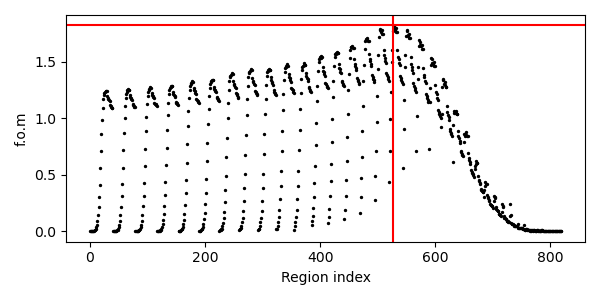

In [23]:
plt.figure(figsize=[6, 3])
plt.scatter(range(len(foms)), foms, s=2, color="k")

plt.axvline(np.argmax(foms), c="r")
plt.axhline(np.max   (foms), c="r")

plt.xlabel("Region index")
plt.ylabel("f.o.m")
plt.tight_layout();

(2.4519999999999964, 2.4679999999999946)


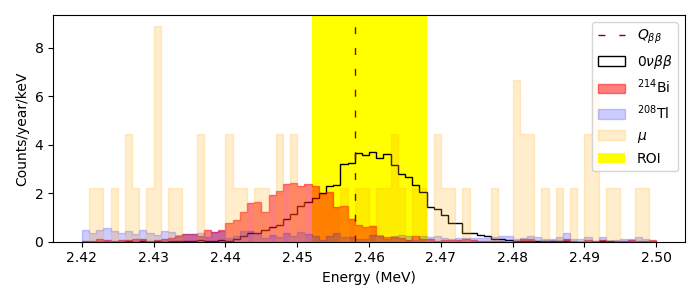

In [24]:
fig = plt.figure(figsize=[7, 3])
ax = fig.add_subplot(111)

bins = np.arange(2.42, 2.50, 0.001)
binc = (bins[1:] + bins[:-1])/2.

# signal
h, _ = np.histogram( tracks_0nubb.loc[sel_0nubb].energy, bins=bins
                   , weights=np.ones(sel_0nubb.sum())/iceff_df.loc[("0nubb", "ACTIVE")].exposure)
ax.stairs(h, bins, label=r"$0\nu\beta\beta$", facecolor="none", edgecolor="k", fill=True)

# 214Bi
h, _ = np.histogram( tracks_214Bi.loc[sel_214Bi].energy, bins=bins
         , weights=1/tracks_214Bi.loc[sel_214Bi].exposure)
ax.stairs(h, bins, label=r"$^{214}$Bi", facecolor="r", edgecolor="r", alpha=0.5, fill=True)


# 208Tl
h, _ = np.histogram( tracks_208Tl.loc[sel_208Tl].energy, bins=bins
         , weights=1/tracks_208Tl.loc[sel_208Tl].exposure)
ax.stairs(h, bins, label=r"$^{208}$Tl", facecolor="b", edgecolor="b", alpha=0.2, fill=True)


# muons
h, _ = np.histogram( tracks_muons.loc[sel_muons].energy, bins=bins
         , weights=1/tracks_muons.loc[sel_muons].exposure)
ax.stairs(h, bins, label=r"$\mu$", facecolor="orange", edgecolor="orange", alpha=0.2, fill=True)


# ROI
Qbb = 2.458
plt.axvline(Qbb, c="darkred", linewidth=1, linestyle=(0, (5, 10)), label=r"$Q_{\beta\beta}$")
ax.set_ylim(ax.get_ylim())
ax.fill_betweenx(ax.get_ylim(), roi[0], roi[1], edgecolor="none", facecolor="yellow", label="ROI")

print(roi)

ax.set_ylabel("Counts/year/keV")
ax.set_xlabel("Energy (MeV)")
ax.legend()
fig.tight_layout()

In [28]:
# plt.figure(figsize=[7, 3])

# bins = np.arange(0, 2.0, 0.02)
# binc = (bins[1:] + bins[:-1])/2.

# plt.hist( tracks_0nubb.loc[sel_0nubb].eblob1, bins=bins, histtype="step", color="k", label=r"$0\nu\beta\beta$"
#         , weights=np.ones(sel_0nubb.sum())/iceff_df.loc[("0nubb", "ACTIVE")].exposure, density=True)

# plt.hist(           tracks_214Bi.loc[sel_214Bi].eblob1, bins=bins, histtype="step", color="r", label=r"$^{214}$Bi"
#         , weights=1/tracks_214Bi.loc[sel_214Bi].exposure, density=True)

# plt.hist(           tracks_208Tl.loc[sel_208Tl].eblob1, bins=bins, histtype="step", color="b", label=r"$^{208}$Tl"
#         , weights=1/tracks_208Tl.loc[sel_208Tl].exposure, density=True)

# plt.ylabel("pdf")
# plt.xlabel(r"E$_{b_1}$ (MeV)")
# plt.legend()
# plt.tight_layout()

In [29]:
# figure of merit
Eb2s = np.arange(0, 1.0, 0.02)

ns  = []
nb1 = []
nb2 = []

for eb2 in Eb2s:
    
    emin, emax = comb
    st  = tracks_0nubb.loc[sel_0nubb & (eb2<tracks_0nubb.eblob2)]
    bt1 = tracks_208Tl.loc[sel_208Tl & (eb2<tracks_208Tl.eblob2)]
    bt2 = tracks_214Bi.loc[sel_214Bi & (eb2<tracks_214Bi.eblob2)]
    
    ns .append(( st.value_counts("G4Volume") / iceff_df.loc[("0nubb", "ACTIVE")].exposure).sum())
    nb1.append((bt1.value_counts("G4Volume") / iceff_df.loc["208Tl"]            .exposure).sum())
    nb2.append((bt2.value_counts("G4Volume") / iceff_df.loc["214Bi"]            .exposure).sum())
    
ns = np.array(ns)
nb = np.array(nb1) +  np.array(nb2)

es = ns/selections_df.loc["0nubb", "overlap"]
eb = nb/selections_df.loc[("208Tl", "214Bi"), :].overlap.sum()

foms = es/np.sqrt(eb)
Eb2 = Eb2s[np.argmax(foms)]

print("Blob energy", Eb2)
print("f.o.m:", np.max(foms))

Blob energy 0.58
f.o.m: 2.2129327820783646


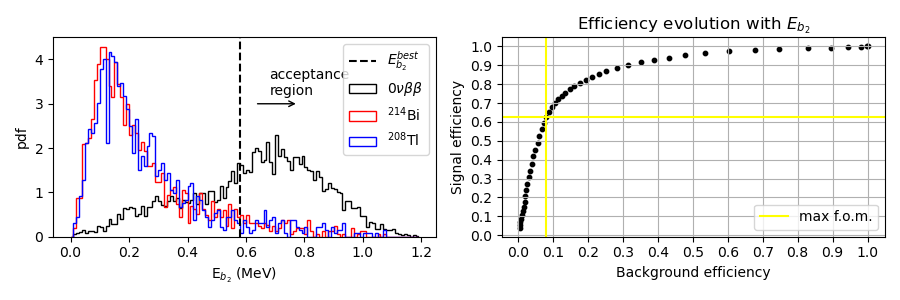

In [30]:
plt.figure(figsize=[9, 3])

bins = np.arange(0, 1.2, 0.01)
binc = (bins[1:] + bins[:-1])/2.

plt.subplot(121)
plt.hist( tracks_0nubb.loc[sel_0nubb].eblob2, bins=bins, histtype="step", color="k", label=r"$0\nu\beta\beta$"
        , weights=np.ones(sel_0nubb.sum())/iceff_df.loc[("0nubb", "ACTIVE")].exposure, density=True)

plt.hist(           tracks_214Bi.loc[sel_214Bi].eblob2, bins=bins, histtype="step", color="r", label=r"$^{214}$Bi"
        , weights=1/tracks_214Bi.loc[sel_214Bi].exposure, density=True)

plt.hist(           tracks_208Tl.loc[sel_208Tl].eblob2, bins=bins, histtype="step", color="b", label=r"$^{208}$Tl"
        , weights=1/tracks_208Tl.loc[sel_208Tl].exposure, density=True)

plt.axvline(Eb2, color="k", linestyle="--", label=r"$E^{best}_{b_{2}}$")
plt.annotate("", xy=(Eb2+0.2, 3), xytext=(Eb2+0.05, 3), 
             arrowprops=dict(arrowstyle="->"))

plt.annotate("acceptance\nregion", xy=(0, 0), xytext=(Eb2+0.1, 3.2))

plt.ylabel("pdf")
plt.xlabel(r"E$_{b_2}$ (MeV)")
plt.legend()
plt.tight_layout()

plt.subplot(122)
plt.title("Efficiency evolution with $E_{b_2}$")

plt.scatter(eb, es, color="k", s=10)

plt.axhline(es[np.argmax(foms)], color="yellow", label="max f.o.m.")
plt.axvline(eb[np.argmax(foms)], color="yellow")

plt.xticks(np.arange(0, 1.1, 0.1))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.grid()
plt.legend()
plt.xlabel("Background efficiency")
plt.ylabel("Signal efficiency")
plt.tight_layout()

In [40]:
# plt.figure(figsize=[5, 3])
# plt.title("Efficiency evolution with $E_{b_2}$")

# plt.scatter(eb, es, color="k", s=10)

# plt.axhline(es[np.argmax(foms)], color="yellow", label="max f.o.m")
# plt.axvline(eb[np.argmax(foms)], color="yellow")

# plt.xticks(np.arange(0, 1.1, 0.1))
# plt.yticks(np.arange(0, 1.1, 0.1))
# plt.grid()
# plt.legend()
# plt.xlabel("Background efficiency")
# plt.ylabel("Signal efficiency")
# plt.tight_layout()

In [41]:
# plt.figure(figsize=[5, 3])
# plt.scatter(Eb2s, foms, s=2, c="k")

# plt.axvline(Eb2s[np.argmax(foms)], c="r")
# plt.axhline(       np.max(foms), c="r")

# plt.ylabel("f.o.m")
# plt.xlabel(r"E$_{b_2}$ (MeV)")
# plt.tight_layout();

In [42]:
# plt.figure(figsize=[7, 3])

# bins = np.arange(0, 1.2, 0.01)
# binc = (bins[1:] + bins[:-1])/2.

# plt.hist( tracks_0nubb.loc[sel_0nubb].eblob2, bins=bins, histtype="step", color="k", label=r"$0\nu\beta\beta$"
#         , weights=np.ones(sel_0nubb.sum())/iceff_df.loc[("0nubb", "ACTIVE")].exposure, density=True)

# plt.hist(           tracks_214Bi.loc[sel_214Bi].eblob2, bins=bins, histtype="step", color="r", label=r"$^{214}$Bi"
#         , weights=1/tracks_214Bi.loc[sel_214Bi].exposure, density=True)

# plt.hist(           tracks_208Tl.loc[sel_208Tl].eblob2, bins=bins, histtype="step", color="b", label=r"$^{208}$Tl"
#         , weights=1/tracks_208Tl.loc[sel_208Tl].exposure, density=True)

# plt.axvline(Eb2, color="k", linestyle="--", label=r"$E^{best}_{b_{2}}$")
# plt.annotate("", xy=(Eb2+0.2, 3), xytext=(Eb2+0.05, 3), 
#              arrowprops=dict(arrowstyle="->"))

# plt.annotate("acceptance\nregion", xy=(0, 0), xytext=(Eb2+0.1, 3.2))

# plt.ylabel("pdf")
# plt.xlabel(r"E$_{b_2}$ (MeV)")
# plt.legend()
# plt.tight_layout()

In [43]:
sel_0nubb = sel_0nubb & tracks_0nubb.energy.between(*roi) & (Eb2<tracks_0nubb.eblob2)
sel_208Tl = sel_208Tl & tracks_208Tl.energy.between(*roi) & (Eb2<tracks_208Tl.eblob2)
sel_214Bi = sel_214Bi & tracks_214Bi.energy.between(*roi) & (Eb2<tracks_214Bi.eblob2)

rate = (tracks_0nubb.loc[sel_0nubb].index.nunique() / iceff_df.loc[("0nubb", "ACTIVE")].exposure).sum()
selections_df.loc["0nubb", "topo"] = rate

# 214Bi
rate = (tracks_214Bi.loc[sel_214Bi].value_counts("G4Volume") / iceff_df.loc["214Bi"].exposure).sum()
selections_df.loc["214Bi", "topo"] = rate

# 208Tl
rate = (tracks_208Tl.loc[sel_208Tl].value_counts("G4Volume") / iceff_df.loc["208Tl"].exposure).sum()
selections_df.loc["208Tl", "topo"] = rate

es = selections_df.loc["0nubb"].topo/selections_df.loc["0nubb"].ROI
eb = selections_df.loc[("208Tl", "214Bi"), :].topo.sum()/selections_df.loc[("208Tl", "214Bi"), :].ROI.sum()

print(f"fiducial cut: fom =", round(es/np.sqrt(eb), 2))

fiducial cut: fom = 2.16


In [44]:
print("Total selection efficiencies E>2 MeV")
print("------------------------------------")
print(selections_df.topo / selections_df.nexus)
print()

signal_eff = (selections_df.topo / selections_df.nexus).loc["0nubb"]

background_rate = selections_df.loc[("208Tl", "214Bi"), :].topo.sum()
print("Total background rate (counts/year):", background_rate)

Total selection efficiencies E>2 MeV
------------------------------------
Isotope
0nubb    0.212267
208Tl    0.002431
214Bi    0.010208
dtype: object

Total background rate (counts/year): 3.58182876271105


In [45]:
selections_df

,nexus,reco,energy,fiducial,track,overlap,ROI,topo
Isotope,,,,,,,,
0nubb,150.000000,125.220000,79.99,75.27,62.51,61.36,46.7,31.84
208Tl,1016.123270,1016.098278,649.653707,561.545813,133.162649,132.713648,26.568589,2.470621
214Bi,108.858939,108.834183,86.042549,81.366072,39.528296,39.378809,9.329302,1.111208


## Selection efficiencies

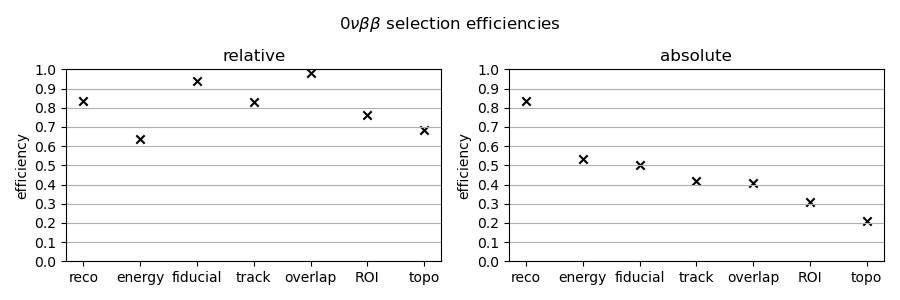

In [46]:
# signal
cuts = selections_df.columns
X = range(len(selections_df.columns))

a = selections_df.loc["0nubb"].values

plt.figure(figsize=[9, 3])
plt.suptitle(r"0$\nu\beta\beta$ selection efficiencies", y=0.95)

plt.subplot(121)
plt.title("relative")
plt.scatter(X[1:], a[1:] / a[:-1], marker="x", color="k", label=r"0$\nu\beta\beta$")
plt.grid(axis="y")
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xticks(X[1:], cuts[1:])
plt.ylabel("efficiency")

plt.subplot(122)
plt.title("absolute")
plt.scatter(X[1:], a[1:] / a[0], marker="x", color="k", label=r"0$\nu\beta\beta$")
plt.grid(axis="y")
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xticks(X[1:], cuts[1:])
plt.ylabel("efficiency")
plt.tight_layout();

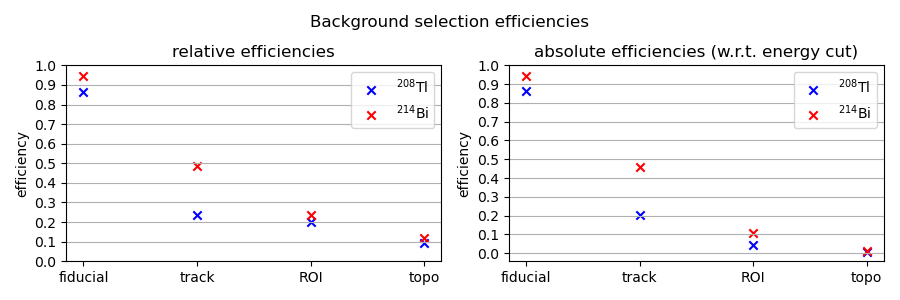

In [48]:
cuts = ["energy", "fiducial", "track", "ROI", "topo"]

X = range(len(cuts))
plt.figure(figsize=[9, 3])

plt.subplot(121)
plt.suptitle(r"Background selection efficiencies", y=0.95)

plt.title("relative efficiencies")
a = selections_df.loc["208Tl", cuts].values
plt.scatter(X[1:], a[1:] / a[:-1], marker="x", color="b", label=r"$^{208}$Tl")
a = selections_df.loc["214Bi", cuts].values
plt.scatter(X[1:], a[1:] / a[:-1], marker="x", color="r", label=r"$^{214}$Bi")
plt.legend(loc="upper right")
plt.grid(axis="y")
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xticks(X[1:], cuts[1:])
plt.ylabel("efficiency");

plt.subplot(122)
plt.title("absolute efficiencies (w.r.t. energy cut)")
a = selections_df.loc["208Tl", cuts].values
plt.scatter(X[1:], a[1:] / a[0], marker="x", color="b", label=r"$^{208}$Tl")
a = selections_df.loc["214Bi", cuts].values
plt.scatter(X[1:], a[1:] / a[0], marker="x", color="r", label=r"$^{214}$Bi")
plt.legend(loc="upper right")
plt.grid(axis="y")
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xticks(X[1:], cuts[1:])
plt.ylabel("efficiency")

plt.tight_layout();

In [49]:
selections_df

,nexus,reco,energy,fiducial,track,overlap,ROI,topo
Isotope,,,,,,,,
0nubb,150.000000,125.220000,79.99,75.27,62.51,61.36,46.7,31.84
208Tl,1016.123270,1016.098278,649.653707,561.545813,133.162649,132.713648,26.568589,2.470621
214Bi,108.858939,108.834183,86.042549,81.366072,39.528296,39.378809,9.329302,1.111208


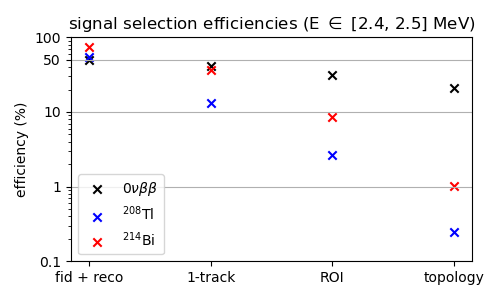

In [64]:
cuts = ["nexus", "fiducial", "track", "ROI", "topo"]

X = range(len(cuts))
fig = plt.figure(figsize=[5, 3])
ax = fig.add_subplot(111)

ax.set_title("signal selection efficiencies (E $\in$ [2.4, 2.5] MeV)")

a = selections_df.loc["0nubb", cuts].values
ax.scatter(X[1:], a[1:] / a[0] *100, marker="x", color="k", label=r"$0\nu\beta\beta$")

a = selections_df.loc["208Tl", cuts].values
ax.scatter(X[1:], a[1:] / a[0] *100, marker="x", color="b", label=r"$^{208}$Tl")

a = selections_df.loc["214Bi", cuts].values
ax.scatter(X[1:], a[1:] / a[0] *100, marker="x", color="r", label=r"$^{214}$Bi")

ax.legend(loc="lower left")

# yaxis
ax.grid(axis="y")
ax.set_yscale("log")
yticks = [1e-3, 1e-2, 1e-1, 5e-1, 1]
yticks = [0.1, 1, 10, 50, 100]
ax.set_yticks(yticks)
ax.set_yticklabels(yticks)

ax.set_xticks(X[1:])
cuts[1] = "fid + reco"
cuts[2] = "1-track"
cuts[4] = "topology"
ax.set_xticklabels(cuts[1:])
ax.set_ylabel("efficiency (%)")

fig.tight_layout();

In [65]:
selections_df.topo / selections_df.nexus

Isotope
0nubb    0.212267
208Tl    0.002431
214Bi    0.010208
dtype: object

In [411]:
# cuts = selections_df.columns
# X = range(len(cuts))

# plt.figure(figsize=[9, 3])

# plt.subplot(121)
# plt.title(r"$^{208}$Tl rates")
# plt.scatter(X, selections_df.loc["208Tl", cuts].values, marker="x", color="b")
# plt.xticks(X, cuts)
# # plt.yticks(np.arange(0, 700, 100))
# plt.grid(axis="y")
# plt.ylabel("counts/year")

# plt.subplot(122)
# plt.title(r"$^{214}$Bi rates")
# plt.scatter(X, selections_df.loc["214Bi", cuts].values, marker="x", color="r")
# plt.xticks(X, cuts)
# # plt.yticks(np.arange(0, 90, 10))
# plt.grid(axis="y")
# plt.ylabel("counts/year")
# plt.tight_layout()

In [31]:
xenon_density = 78.949 * kg/m3
volume          = np.pi*(490*mm)**2*1200*mm
# fiducial_volume = np.pi*(rmax*mm)**2*(zmax-zmin)*mm
xenon_mass = (xenon_density * volume)

In [32]:
print("Background rate (counts/keV/year/kg):", background_rate / ((roi[-1] - roi[0])*1e3*xenon_mass/kg))

Background rate (counts/keV/year/kg): 0.0036101488341963245


In [33]:
# rate per component
rates = pd.DataFrame()
r = (tracks_214Bi.loc[sel_214Bi].value_counts("G4Volume") / iceff_df.loc["214Bi"].exposure).to_frame()
r.loc[:, "Isotope"] = "214Bi"
rates = pd.concat([rates, r])
r = (tracks_208Tl.loc[sel_208Tl].value_counts("G4Volume") / iceff_df.loc["208Tl"].exposure).to_frame()
r.loc[:, "Isotope"] = "208Tl"
rates = pd.concat([rates, r]).rename({0: "rate"}, axis=1).fillna(0)
rates = rates.reset_index().set_index(["Isotope", "G4Volume"])

In [34]:
# is upper limit?
rates.loc[:, "upperlim"] = False

rates.loc[("214Bi", "ICS")       , "upperlim"] = True
rates.loc[("214Bi", "FIELD_RING"), "upperlim"] = True
rates.loc[("214Bi", "SIPM_BOARD"), "upperlim"] = True
rates.loc[("214Bi", "VESSEL")    , "upperlim"] = True
rates.loc[("214Bi", "SHIELDING_LEAD"), "upperlim"] = True

rates.loc[("208Tl", "ICS")       , "upperlim"] = True
rates.loc[("208Tl", "FIELD_RING"), "upperlim"] = True
rates.loc[("208Tl", "SIPM_BOARD"), "upperlim"] = True
rates.loc[("208Tl", "VESSEL")    , "upperlim"] = True

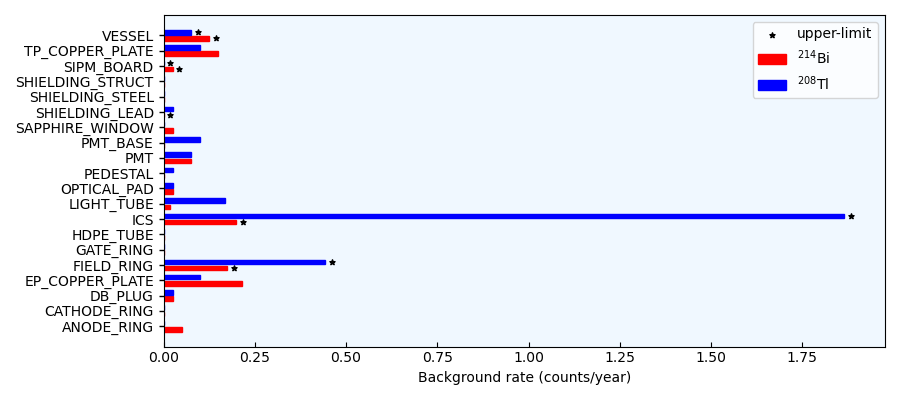

In [35]:
width = 3
dx = 10
volumes = rates.index.get_level_values("G4Volume").unique()
X = np.arange(0, dx*len(volumes), dx)
tick_width = 1

fig = plt.figure(figsize=[9, 4])
ax = fig.add_subplot(111)

# 214Bi
color="r"
b1 = ax.barh( X-width/2.-tick_width/2., rates.loc["214Bi"].rate, height=width
             , color=color, edgecolor=color, label=r"$^{214}$Bi")
# 208Tl
color="b"
b2 = ax.barh( X+width/2.+tick_width/2., rates.loc["208Tl"].rate, height=width
             , color=color, edgecolor=color, label=r"$^{208}$Tl")

# upper limits
du = rates.rate.max()*0.01

isupp = rates.loc["214Bi"].upperlim
ax.scatter( rates.loc["214Bi"].rate.loc[isupp] + du, X[isupp]-width/2.-tick_width/2, marker="*"
           , color="k", s=15, label="upper-limit")

isupp = rates.loc["208Tl"].upperlim
ax.scatter( rates.loc["208Tl"].rate.loc[isupp] + du, X[isupp]+width/2.+tick_width/2, marker="*"
           , color="k", s=15)

# ax.set_xticks(np.arange(0, rates.rate.max(), 10))
ax.set_yticks(X)
ax.set_yticklabels(volumes, rotation=0)
ax.tick_params(axis='y', width=tick_width)
ax.tick_params(axis='x', direction="in")
ax.ticklabel_format(axis="x", scilimits=(-1, 2))
ax.set_xlabel("Background rate (counts/year)")
ax.legend()

ax.set_facecolor("aliceblue")
fig.tight_layout()

In [36]:
rates.loc["214Bi"].rate.sum()

1.104814543931711

In [37]:
rates.loc["208Tl"].rate.sum()

3.0229508113156505

In [38]:
# act_df.loc[:, "upperlim"] = rates.upperlim

# width = 3
# dx = 10
# volumes = act_df.index.get_level_values("G4Volume").unique()
# X = np.arange(0, dx*len(volumes), dx)
# tick_width = 1

# fig = plt.figure(figsize=[9, 4])
# ax = fig.add_subplot(111)

# # 214Bi
# color="r"
# b1 = ax.barh( X-width/2.-tick_width/2., act_df.loc["214Bi"].TotalActivity, height=width
#              , color=color, edgecolor=color, label=r"$^{214}$Bi")
# # 208Tl
# color="b"
# b2 = ax.barh( X+width/2.+tick_width/2., act_df.loc["208Tl"].TotalActivity, height=width
#              , color=color, edgecolor=color, label=r"$^{208}$Tl")

# # upper limits
# du = 10

# isupp = act_df.loc["214Bi"].upperlim
# ax.scatter( act_df.loc["214Bi"].TotalActivity.loc[isupp] + du, X[isupp]-width/2.-tick_width/2, marker="*"
#            , color="k", s=15, label="upper-limit")

# isupp = act_df.loc["208Tl"].upperlim
# ax.scatter( act_df.loc["208Tl"].TotalActivity.loc[isupp] + du, X[isupp]+width/2.+tick_width/2, marker="*"
#            , color="k", s=15)

# ax.set_xticks(np.arange(0, 5000, 100))
# ax.set_xlim(0, 1000)
# ax.set_yticks(X)
# ax.set_yticklabels(volumes, rotation=0)
# ax.tick_params(axis='y', width=tick_width)
# ax.tick_params(axis='x', direction="in")
# ax.ticklabel_format(axis="x", scilimits=(-1, 4))
# ax.set_xlabel("Activity (mBq)")
# ax.legend()

# ax.set_facecolor("aliceblue")
# fig.tight_layout()

## $T^{0\nu\beta\beta}_{1/2}$

In [453]:
os.sys.path.append("/Users/gonzalo/NEXT/pybbsens/")
from pybbsens.conflimits import FeldmanCousins

def mean_upper_limit(b, cl=90):
    fc = FeldmanCousins(cl)
    s = []
    for bs in b: s.append(fc.AverageUpperLimit(bs))
    return np.array(s)

In [454]:
xenon_density = 78.949 * kg/m3
volume     = np.pi*(490*mm)**2*1200*mm
xenon_mass = (xenon_density * volume)
enrichment = 0.9
N0 = enrichment*(xenon_mass/(136. * dalton))

tmax = 5
t = np.arange(1, tmax+0.25, 0.25)

t0 = time.time()
T12_90 = np.log(2.) * t * signal_eff * N0 / mean_upper_limit(background_rate*t, 90)
T12_95 = np.log(2.) * t * signal_eff * N0 / mean_upper_limit(background_rate*t, 95)

print("Time (min):", (time.time()-t0)/60.)

Time (min): 4.214630949497223


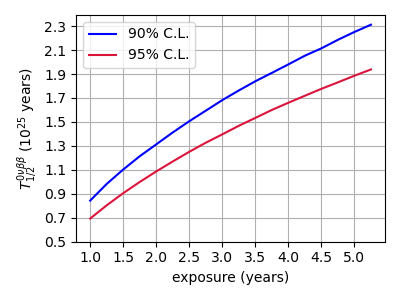

In [459]:
# plot
plt.figure(figsize=[4, 3])

# alpha = 1.64 # CL 90
# T12 = np.log(2) * t * signal_eff * N0 / (np.sqrt(background_rate * t) * alpha)
# plt.plot(t, T12/1e25, color="crimson", label="approx")

plt.plot(t, T12_90/1e25, color=   "blue", label="90% C.L.")
plt.plot(t, T12_95/1e25, color="crimson", label="95% C.L.")

plt.xticks(np.arange(1., tmax+0.5, 0.5))
plt.yticks(np.arange(0.5, 2.5, 0.2))
plt.xlabel("exposure (years)")
plt.ylabel(r"$T^{0\nu\beta\beta}_{1/2}$ ($10^{25}$ years)")
plt.grid()
plt.legend()
plt.tight_layout()

In [460]:
enrichment = 0.9
N0 = enrichment*(xenon_mass/(136. * dalton))

tmax = 5
t = np.arange(1, tmax+0.5, 0.25)

t0 = time.time()

df = rates.copy()
df.loc[rates.upperlim, "rate"] = df.loc[rates.upperlim, "rate"]/2.
print("Half rate:", df.rate.sum())
T12_90_half = np.log(2.) * t * signal_eff * N0 / mean_upper_limit(df.rate.sum()*t, 90)

df = rates.copy()
df.loc[rates.upperlim, "rate"] = df.loc[rates.upperlim, "rate"]/10.
print("Tenth rate:", df.rate.sum())
T12_90_tenth = np.log(2.) * t * signal_eff * N0 / mean_upper_limit(df.rate.sum()*t, 90)

print("Time (min):", (time.time()-t0)/60.)

Half rate: 2.6754918246184127
Tenth rate: 1.5136730001152539
Time (min): 2.8864562153816222


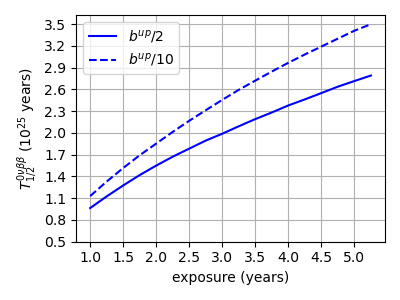

In [469]:
# plot
plt.figure(figsize=[4, 3])

# alpha = 1.64 # CL 90
# T12 = np.log(2) * t * signal_eff * N0 / (np.sqrt(background_rate * t) * alpha)
# plt.plot(t, T12/1e25, color="crimson", label="approx")

plt.plot(t, T12_90_half /1e25, color="blue", label="$b^{up}$/2")
plt.plot(t, T12_90_tenth/1e25, color="blue", label="$b^{up}$/10", linestyle="dashed")

plt.xticks(np.arange(1., tmax+0.5, 0.5))
plt.yticks(np.arange(0.5, 3.7, 0.3))
plt.xlabel("exposure (years)")
plt.ylabel(r"$T^{0\nu\beta\beta}_{1/2}$ ($10^{25}$ years)")
plt.grid()
plt.legend()
plt.tight_layout()

## PDFs

In [6]:
os.environ["ZFIT_DISABLE_TF_WARNINGS"] = "1"
import zfit
import hist

/Users/gonzalo/miniconda/envs/IC-3.8-2022-04-13/lib/python3.8/site-packages/zfit/__init__.py:50: UserWarning: This is an ALPHA version of zfit for feature testing, do NOT use it in production! It is NOT stable and contains bugs and untested features. For production use, please use the last beta stable version of zfit.
  warnings.warn(


### Energy

In [7]:
energy_obs_ext = zfit.Space("energy", limits=(2.40, 2.50))
energy_obs     = zfit.Space("energy", limits=(2.42, 2.49))

data = zfit.Data.from_numpy (obs=energy_obs_ext, array=tracks_0nubb.energy.values)
pdf_energy_0nubb = zfit.pdf.KDE1DimExact(obs=energy_obs, data=data, bandwidth="adaptive_zfit")

data = zfit.Data.from_numpy (obs=energy_obs_ext, array=tracks_214Bi.energy.values)
pdf_energy_214Bi = zfit.pdf.KDE1DimExact(obs=energy_obs, data=data, bandwidth="adaptive_zfit")

data = zfit.Data.from_numpy (obs=energy_obs_ext, array=tracks_208Tl.energy.values)
pdf_energy_208Tl = zfit.pdf.KDE1DimExact(obs=energy_obs, data=data, bandwidth="adaptive_zfit")

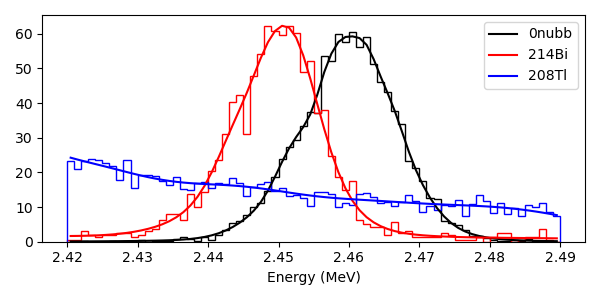

In [381]:
plt.figure(figsize=[6, 3])

bins = np.arange(2.42, 2.49, 0.001)
binc = (bins[1:] + bins[:-1])/2.

plt.hist(tracks_0nubb.energy, bins=bins, density=True, histtype="step", color="k")
plt.hist(tracks_214Bi.energy, bins=bins, density=True, histtype="step", color="r")
plt.hist(tracks_208Tl.energy, bins=bins, density=True, histtype="step", color="b")

plt.plot(binc, pdf_energy_0nubb.pdf(binc), label="0nubb", color="k")
plt.plot(binc, pdf_energy_214Bi.pdf(binc), label="214Bi", color="r")
plt.plot(binc, pdf_energy_208Tl.pdf(binc), label="208Tl", color="b")

plt.xlabel("Energy (MeV)")
plt.legend()
plt.tight_layout()

### Energy resolution

In [382]:
from scipy.signal import find_peaks, peak_widths

In [383]:
signal = pdf_energy_0nubb.pdf(binc).numpy()

peaks, _ = find_peaks(signal)
fwhm, heigh, x1, x2 = peak_widths(signal, peaks, rel_height=0.5)

x_to_energy = lambda x: (binc[-1] - binc[0])/len(signal)*x + binc[0]
R = (x_to_energy(x2) - x_to_energy(x1)) / x_to_energy(peaks) * 100

print("Energy resolution FWHM (%)", R)

Energy resolution FWHM (%) [0.62197527]


In [365]:
# gaussian fit
import zfit

obs = zfit.Space('x', limits=(2.42, 2.49))

mu    = zfit.Parameter(   "mu", 2.45, 2.42, 2.49)
sigma = zfit.Parameter("sigma", 0.10, 0.00, 5.00)

gauss = zfit.pdf.Gauss(obs=obs, mu=mu, sigma=sigma)
minimizer = zfit.minimize.Minuit()

In [384]:
data = zfit.Data.from_numpy(obs=obs, array=tracks_0nubb.energy.values)

nll = zfit.loss.UnbinnedNLL(model=gauss, data=data)

result = minimizer.minimize(nll)
print(result)

FitResult of
<UnbinnedNLL model=[<zfit.<class 'zfit.models.dist_tfp.Gauss'>  params=[mu1, sigma]] data=[<zfit.core.data.Data object at 0x7fec1c97d970>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm     │ min value   │
╞═════════╪═════════════╪══════════════════╪═════════╪═════════════╡
│ True    │ True        │ False            │ 6.1e-12 │ 1000        │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name         value    at limit
------  ----------  ----------
mu1        2.45981       False
sigma   0.00719675       False


In [390]:
# plt.figure(figsize=[5, 3])

# plt.plot  (x_to_energy(range(len(signal))), signal, color="k")
# plt.plot  (x_to_energy(peaks), signal[peaks], "x", color="r")
# plt.hlines(heigh, x_to_energy(x1), x_to_energy(x2), color="r")


# plt.xlabel("Energy (MeV)")
# plt.tight_layout()

### $E_{b_2}$

In [96]:
energy_obs     = zfit.Space("eblob2", limits=(0, 1.2))

data = zfit.Data.from_numpy (obs=energy_obs, array=tracks_0nubb.eblob2.values)
pdf_energy_0nubb = zfit.pdf.KDE1DimExact(obs=energy_obs, data=data, bandwidth="adaptive_zfit")

data = zfit.Data.from_numpy (obs=energy_obs, array=tracks_214Bi.eblob2.values)
pdf_energy_214Bi = zfit.pdf.KDE1DimExact(obs=energy_obs, data=data, bandwidth="adaptive_zfit")

data = zfit.Data.from_numpy (obs=energy_obs, array=tracks_208Tl.eblob2.values)
pdf_energy_208Tl = zfit.pdf.KDE1DimExact(obs=energy_obs, data=data, bandwidth="adaptive_zfit")

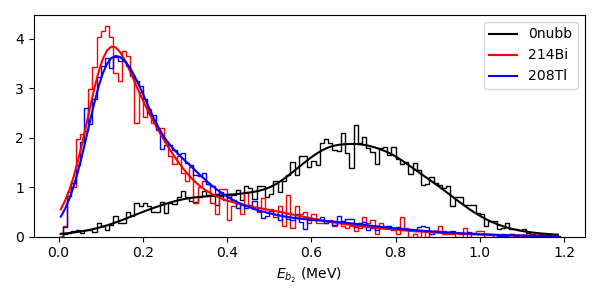

In [97]:
plt.figure(figsize=[6, 3])

bins = np.arange(0, 1.2, 0.01)
binc = (bins[1:] + bins[:-1])/2.

plt.hist(tracks_0nubb.eblob2, bins=bins, density=True, histtype="step", color="k")
plt.hist(tracks_214Bi.eblob2, bins=bins, density=True, histtype="step", color="r")
plt.hist(tracks_208Tl.eblob2, bins=bins, density=True, histtype="step", color="b")

plt.plot(binc, pdf_energy_0nubb.pdf(binc), label="0nubb", color="k")
plt.plot(binc, pdf_energy_214Bi.pdf(binc), label="214Bi", color="r")
plt.plot(binc, pdf_energy_208Tl.pdf(binc), label="208Tl", color="b")

plt.xlabel(r"$E_{b_2}$ (MeV)")
plt.legend()
plt.tight_layout()

In [98]:
save_data = False
data_filename = "selected_data.h5"

if save_data:
    with tb.open_file(data_filename, mode="w", title="PDFs") as h5file:
        
        # 208Tl
        g = h5file.create_group("/", "Tl208", "Tl208")
        h5file.create_array(g, "energy", tracks_208Tl.energy.values, "energy")
        h5file.create_array(g, "eblob2", tracks_208Tl.eblob2.values, "eblob2")
        
        # 214Bi
        g = h5file.create_group("/", "Bi214", "Bi214")
        h5file.create_array(g, "energy", tracks_214Bi.energy.values, "energy")
        h5file.create_array(g, "eblob2", tracks_214Bi.eblob2.values, "eblob2")
        
        # 0nubb
        g = h5file.create_group("/", "bb0nu", "bb0nu")
        h5file.create_array(g, "energy", tracks_0nubb.energy.values, "energy")
        h5file.create_array(g, "eblob2", tracks_0nubb.eblob2.values, "eblob2")

### ROI efficiencies (for pdf-based event mixer)

In [359]:
ic_efficiencies = "efficiencies_ic.csv"
eff_ic = pd.read_csv(ic_efficiencies).set_index(["Isotope", "G4Volume"])

pdf_roi = 2.42, 2.49

n_roi_0nubb = tracks_0nubb.energy.between(*pdf_roi).sum()
print("0nubb eff:", n_roi_0nubb/eff_ic.loc[("0nubb", "ACTIVE")].nreco)

sel = tracks_208Tl.energy.between(*pdf_roi)
n_roi_208Tl = tracks_208Tl.loc[sel].value_counts("G4Volume").to_frame()

sel = tracks_214Bi.energy.between(*pdf_roi)
n_roi_214Bi = tracks_214Bi.loc[sel].value_counts("G4Volume").to_frame()

0nubb eff: 0.5039929723686312


In [360]:
n_roi_208Tl.loc[:, "Isotope"] = "208Tl"
n_roi_214Bi.loc[:, "Isotope"] = "214Bi"

n_roi = pd.concat([n_roi_208Tl, n_roi_214Bi])
n_roi.loc["ACTIVE"] = (n_roi_0nubb, "0nubb")
n_roi = n_roi.rename({0: "nevts"}, axis=1).reset_index()

In [361]:
save = True
if save:
    n_roi.to_csv("efficiencies_selection.csv", index=False)

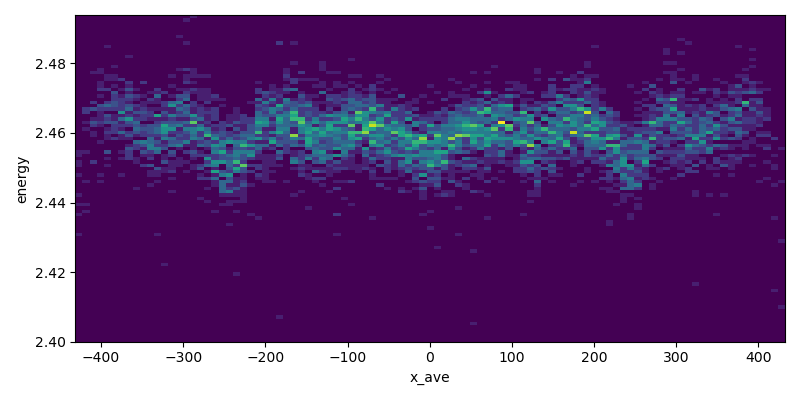

In [117]:
plt.figure(figsize=[8, 4])

xlabel = "x_ave"
ylabel = "energy"

x = tracks_0nubb.get(xlabel)
y = tracks_0nubb.get(ylabel)

xbins = np.linspace(x.min(), x.max(), 100)
ybins = np.linspace(2.4, y.max(), 100)

plt.hist2d( x, y, bins=[xbins, ybins])

plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.tight_layout();

In [129]:
# from invisible_cities.reco.corrections import read_maps

# maps = read_maps("/Users/gonzalo/NEXT/DATA/production/LightTables/map_NEXT100_MC.h5")

# plt.figure(figsize=[9, 3])
# plt.subplot(121)
# plt.imshow(maps.e0)

# plt.subplot(122)
# plt.imshow(maps.lt)

# plt.tight_layout()